In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16
from torchvision import transforms
import torch.optim as optim

from torch.utils.data import random_split, ConcatDataset
from torchvision import datasets, transforms
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchvision.models import get_model, get_model_weights, get_weight, list_models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.transforms.functional import normalize, to_tensor, resize, to_pil_image

from pathlib import Path
from PIL import ImageEnhance
from PIL import Image

from tqdm import tqdm

/apps/pytorch/2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/apps/pytorch/2.0.1/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# hyper params
batch_size = 128
learning_rate = 0.001
epochs = 100

basepath = Path('/home/alexwebber/toorange/alexwebber/mixteclabeling') # Base data directory
path_v = basepath / 'data/labeled_figures/codex_vindobonensis/seated/'
path_n = basepath / 'data/labeled_figures/codex_nuttall/seated/'
path_s = basepath / 'data/labeled_figures/codex_selden/seated/'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((227, 227), antialias=True),
     # transforms.Grayscale(),
     
     #transforms.ColorJitter(contrast=0.5),
     #transforms.RandomRotation(360),     # Maybe useful for standng and sitting
     #transforms.RandomHorizontalFlip(50),
     #transforms.RandomVerticalFlip(50)
])

## Load images into PyTorch dataset
vindobonensis_dataset = datasets.ImageFolder(path_v, transform=transform)
nuttall_dataset = datasets.ImageFolder(path_n, transform=transform)
selden_dataset = datasets.ImageFolder(path_s, transform=transform)

figures_dataset = ConcatDataset([vindobonensis_dataset, nuttall_dataset, selden_dataset])

train_set, test_set = random_split(figures_dataset, [0.8, 0.2])

dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size,  shuffle = True)

gender_dict = {0: "female", 1: "male"}

In [3]:
reference_images = [#"../reference_images/female/003-a-05.png",
                        #"../reference_images/female/003-a-06.png",
                        #"../reference_images/female/072-a-04.png",
                        #"../reference_images/male/001-a-04.png",
                        #"../reference_images/male/067-a-09.png",
                        "../reference_images/male/013-a-10.png"
                        ]

data = [transform(Image.open(ref).convert("RGB")) for ref in reference_images]

data = torch.stack(data)

type(data)
data.shape

torch.Size([1, 3, 227, 227])

In [4]:
### RANDOM IMAGE ###

# data, _ = next(iter(dataloader))
# print(data.shape)
# type(data)

In [5]:
image = transforms.ToPILImage()(data[0])

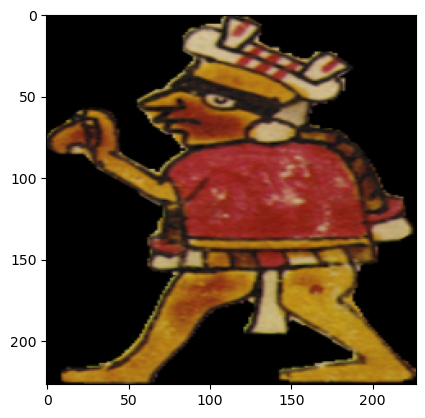

In [6]:
plt.imshow(image)

In [7]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer_names = ['conv1', 'conv2', 'conv3', 'conv4']
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * (227//16) * (227//16), 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        activations = {}
        
        x = self.relu(self.conv1(x))
        activations[self.conv_layer_names[0]] = x
        x = self.maxpool(x)
        
        x = self.relu(self.conv2(x))
        activations[self.conv_layer_names[1]] = x
        x = self.maxpool(x)
        
        x = self.relu(self.conv3(x))
        activations[self.conv_layer_names[2]] = x
        x = self.maxpool(x)
        
        x = self.relu(self.conv4(x))
        activations[self.conv_layer_names[3]] = x
        x = self.maxpool(x)
        
        # Flatten the feature maps for fully connected layers
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        sigmoid_output = torch.sigmoid(x)
        
        return sigmoid_output, activations
    

In [8]:
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

## Unfreeze layers
for param in model.parameters():
    param.requires_grad = True

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [10]:
for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions, activations = model(inputs)

        # Get the output from the last layer
        outputs = predictions

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    model.eval()

    data = data.cuda()

    preds, out = model(data)
    
    class_probability = torch.nn.functional.softmax(preds, dim=1)
    
    if(class_probability[0][0].item() > class_probability[0][1].item()):
        predicted_class = gender_dict[0]
        prediction_strength = round(class_probability[0][0].item(), 2)
        
    elif(class_probability[0][0].item() < class_probability[0][1].item()):
        predicted_class = gender_dict[1]
        prediction_strength = round(class_probability[0][1].item(), 2)

    ind = 1

    plt.figure(figsize=[20, 50])

    ## Calculating average activation in outputs
    for layer in out:
        mean = torch.zeros(np.shape(out[layer])[2], np.shape(out[layer])[3])
        mean = mean.cuda()
        for i in out[layer][0]:
            mean += i
        vis_mean = transforms.ToPILImage()(mean/np.shape(out[layer])[1])
        plot_loc = plt.subplot(13, 3, ind)

        ind += 1    
        plt.imshow(vis_mean,cmap='magma')
        
        plt.title(f'Epoch: {epoch + 1} | {reference_images[0][-12:-4]} | Layer: {layer} | {predicted_class}/{prediction_strength}')
        plt.colorbar()

    plt.savefig(f'images/013-a-10/{epoch:05d}.png')

    plt.close()

    model.train()

    print(f"Epoch {epoch+1}/{epochs} loss: {loss.item()}")

Epoch 1/100 loss: 0.7043497562408447
Epoch 2/100 loss: 0.7030847072601318
Epoch 3/100 loss: 0.6935121417045593
Epoch 4/100 loss: 0.6928877234458923
Epoch 5/100 loss: 0.6933314204216003
Epoch 6/100 loss: 0.6973244547843933
Epoch 7/100 loss: 0.6955462098121643
Epoch 8/100 loss: 0.6923617124557495
Epoch 9/100 loss: 0.6931723356246948
Epoch 10/100 loss: 0.6924904584884644
Epoch 11/100 loss: 0.6930996179580688
Epoch 12/100 loss: 0.6772595643997192
Epoch 13/100 loss: 0.7044752836227417
Epoch 14/100 loss: 0.6816497445106506
Epoch 15/100 loss: 0.6780945062637329
Epoch 16/100 loss: 0.6545459032058716
Epoch 17/100 loss: 0.6724872589111328
Epoch 18/100 loss: 0.673031210899353
Epoch 19/100 loss: 0.6956610679626465
Epoch 20/100 loss: 0.6980565190315247
Epoch 21/100 loss: 0.6575218439102173
Epoch 22/100 loss: 0.745883584022522
Epoch 23/100 loss: 0.6945670247077942
Epoch 24/100 loss: 0.5733414888381958
Epoch 25/100 loss: 0.7834718227386475
Epoch 26/100 loss: 0.615026593208313
Epoch 27/100 loss: 0.703

<video controls src="cam_output/001-a-04/screens.mp4" />

### Save model

In [11]:
savepath = "../models/mixtec_gender_classifier.pth"

torch.save(model.state_dict(), savepath)

# Testing

### Load images and labels from test_loader

In [12]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

### Load model

In [13]:
cnn = CNN()
cnn.load_state_dict(torch.load(savepath))
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

### Produce predictions and calculate accuracy of model

In [14]:
cnn.eval()

predicted_list = []
target_list = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        target_list += labels.cpu()
        
        # calculate outputs by running images through the network
        outputs = cnn(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs[0].data, 1)
        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

Accuracy of the network on the 257 test images: 69 %


In [15]:
metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics = [BinaryAccuracy(), BinaryPrecision(), BinaryRecall(), BinaryF1Score()]

for metric, name in zip(metrics, metric_names):
    metric.update(torch.tensor(predicted_list), torch.tensor(target_list))
    print(f"{name:<9}: {metric.compute()}")

Accuracy : 0.6964980363845825
Precision: 0.6964980363845825
Recall   : 1.0
F1       : 0.8211008906364441
